In [ ]:
import json
import csv
import io
import os
from google.colab import drive
from docx import Document
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Specify the folder path in your Google Drive
folder_path = '/content/drive/MyDrive/Flights Data/Flights Data'  # Update this path

# Function to flatten a nested dictionary
def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

# List to store all flattened data
all_flat_data = []

# Process each .docx file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.docx'):
        file_path = os.path.join(folder_path, filename)

        # Read the .docx file
        doc = Document(file_path)

        # Extract the text from the document
        text = " ".join([para.text for para in doc.paragraphs])

        try:
            # Parse the JSON data
            data = json.loads(text)

            # Flatten each flight dictionary
            flat_data = [flatten_dict(flight) for flight in data]

            # Add to the list of all flattened data
            all_flat_data.extend(flat_data)
        except json.JSONDecodeError:
            print(f"Error decoding JSON in file: {filename}")

# Create a DataFrame from all the flattened data
df = pd.DataFrame(all_flat_data)

# Save the DataFrame as a CSV file
csv_filename = 'combined_flight_data.csv'
csv_path = os.path.join(folder_path, csv_filename)
df.to_csv(csv_path, index=False)

print(f"CSV file '{csv_filename}' has been created and saved to {csv_path}")

# Display the first few rows of the DataFrame
print(df.head())

# Print some basic statistics
print(df.describe())

# Print the total number of flights processed
print(f"Total number of flights processed: {len(df)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV file 'combined_flight_data.csv' has been created and saved to /content/drive/MyDrive/Flights Data/Flights Data/combined_flight_data.csv
        type  status departure_iataCode departure_icaoCode departure_terminal  \
0  departure  active                lhe               opla                  m   
1  departure  active                lhe               opla                  m   
2  departure  active                lhe               opla                  m   
3  departure  active                lhe               opla                  m   
4  departure  active                lhe               opla                  m   

   departure_delay  departure_scheduledTime  departure_estimatedTime  \
0             10.0  2023-07-13t06:00:00.000  2023-07-13t06:10:00.000   
1             10.0  2023-07-13t06:00:00.000  2023-07-13t06:10:00.000   
2             20.0  2023-07-

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-18-70e8eef37629>:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=column, y='arrival_delay', data=data, ci=None)


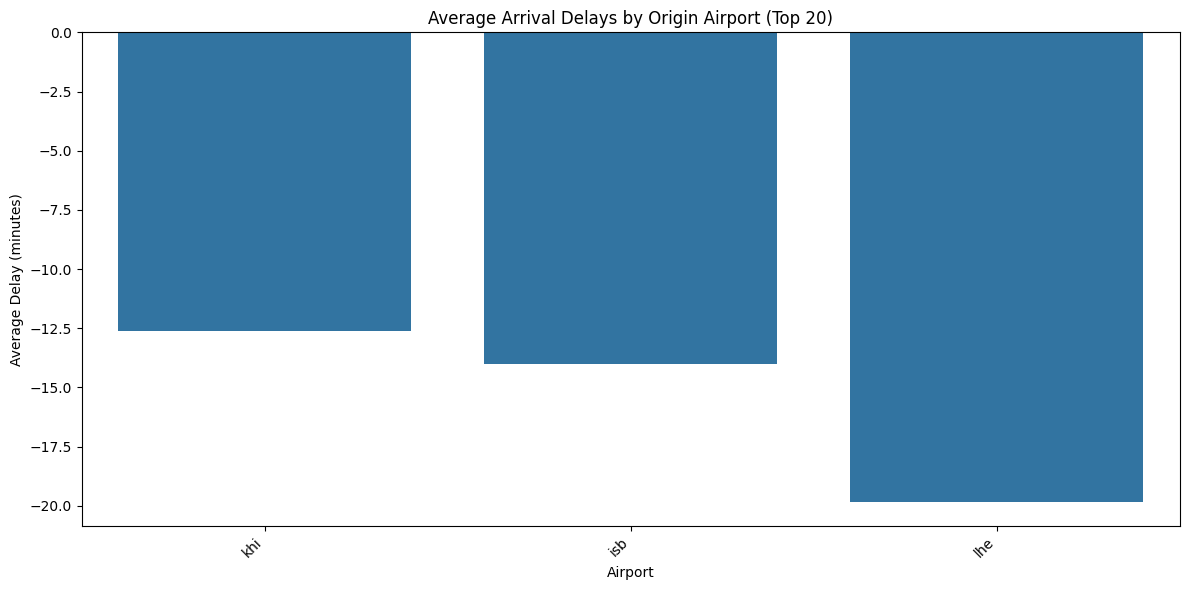

<ipython-input-18-70e8eef37629>:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=column, y='arrival_delay', data=data, ci=None)


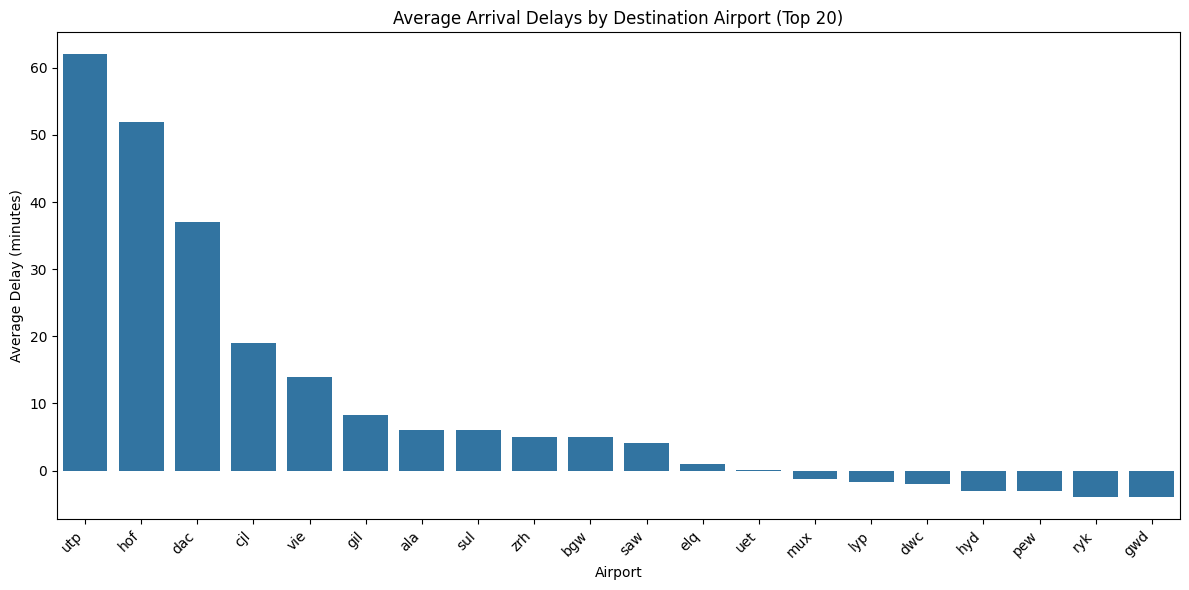

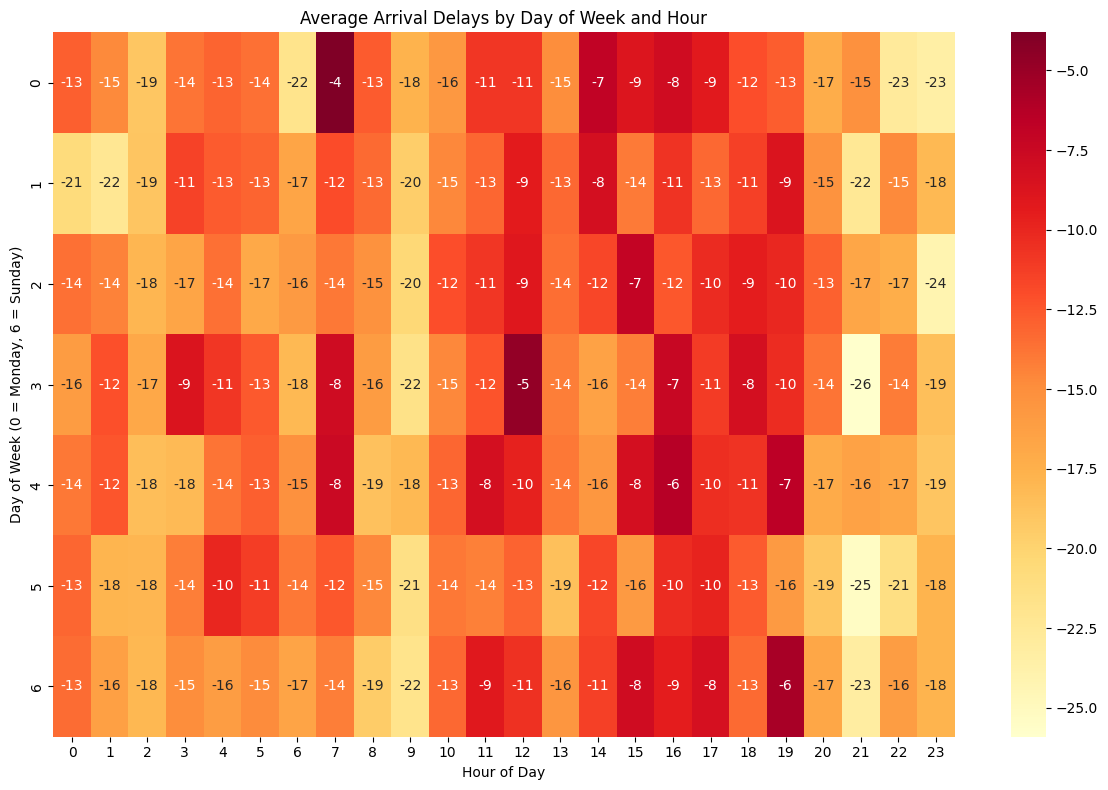

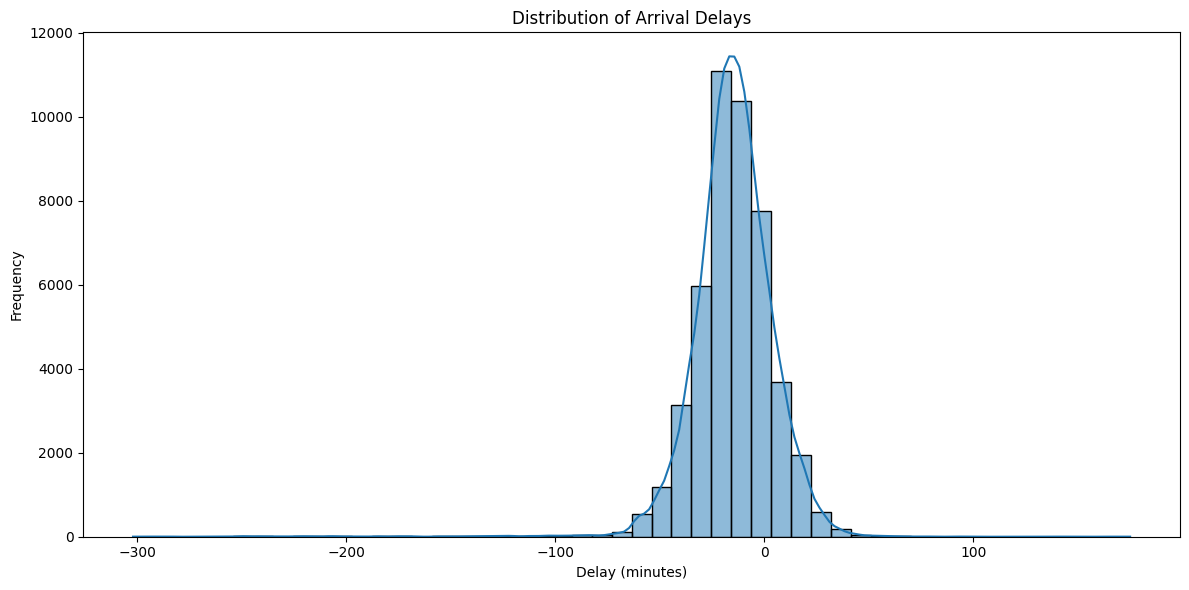

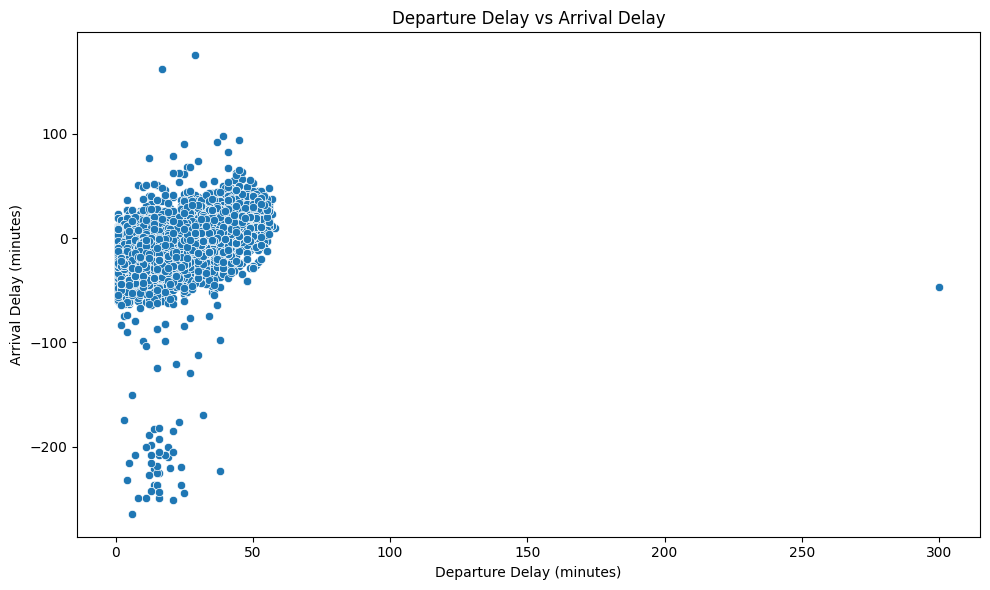

EDA visualizations completed.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Load the CSV file
csv_path = '/content/drive/MyDrive/Flights Data/Flights Data/combined_flight_data.csv'
df = pd.read_csv(csv_path)

# Convert time columns to datetime
time_columns = ['departure_scheduledTime', 'departure_estimatedTime', 'departure_actualTime',
                'arrival_scheduledTime', 'arrival_estimatedTime']
for col in time_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col])

# Calculate arrival delay
df['arrival_delay'] = (df['arrival_estimatedTime'] - df['arrival_scheduledTime']).dt.total_seconds() / 60

# Function to plot average delays
def plot_average_delays(data, column, title):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=column, y='arrival_delay', data=data, ci=None)
    plt.title(title)
    plt.xlabel('Airport')
    plt.ylabel('Average Delay (minutes)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Average delays by origin airport
origin_delays = df.groupby('departure_iataCode')['arrival_delay'].mean().reset_index()
origin_delays = origin_delays.sort_values('arrival_delay', ascending=False).head(20)
plot_average_delays(origin_delays, 'departure_iataCode', 'Average Arrival Delays by Origin Airport (Top 20)')

# Average delays by destination airport
dest_delays = df.groupby('arrival_iataCode')['arrival_delay'].mean().reset_index()
dest_delays = dest_delays.sort_values('arrival_delay', ascending=False).head(20)
plot_average_delays(dest_delays, 'arrival_iataCode', 'Average Arrival Delays by Destination Airport (Top 20)')

# Heatmap of delays by day of week and hour
df['day_of_week'] = df['departure_scheduledTime'].dt.dayofweek
df['hour'] = df['departure_scheduledTime'].dt.hour
delay_heatmap = df.pivot_table(values='arrival_delay', index='day_of_week', columns='hour', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(delay_heatmap, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Average Arrival Delays by Day of Week and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.tight_layout()
plt.show()

# Distribution of arrival delays
plt.figure(figsize=(12, 6))
sns.histplot(df['arrival_delay'], kde=True, bins=50)
plt.title('Distribution of Arrival Delays')
plt.xlabel('Delay (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Correlation between departure delay and arrival delay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='departure_delay', y='arrival_delay', data=df)
plt.title('Departure Delay vs Arrival Delay')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Arrival Delay (minutes)')
plt.tight_layout()
plt.show()

print("EDA visualizations completed.")